In [1]:
# manejo de datos
import numpy as np
import pandas as pd
# incertidumbres
from numpy.random import normal
from numpy.random import uniform
from numpy.random import multivariate_normal as mnormal
# graficación
import matplotlib.pyplot as plt
# Datos
import json
# Ajuste
from scipy.optimize import curve_fit
print("Todas las librerías han sido importadas")

Todas las librerías han sido importadas


In [2]:
N=10**6

# Procesamiendo de datos de calibraciones en Temperatura y Resistencia

In [3]:
with open(r'Datos\DatosCalibracionResistencia.json') as json_file:
    datar = json.load(json_file)

In [4]:
with open(r'Datos\DatosCalibracionTemperatura.json') as json_file:
    datat = json.load(json_file)

In [5]:
with open(r'Datos\DatosMedicionConductividad.json') as json_file:
    datak = json.load(json_file)

Se tienen las funciones que estiman el valor medio a partir de varios conjuntos de datos con medias y desviaciones estándar asociadas:

$$\bar{x}=\frac{\sum_{i=1}^n\bar{x}_i/s_i^2}{\sum_{i=1}^n1/s_i^2}$$

$$u(\bar{x})=\sqrt{\frac{n}{n-1}\frac{\sum_{i=1}^n\left(\bar{x}_i-\bar{x}\right)^2/s_i^2}{\sum_{i=1}^n1/s_i^2}}$$

Las funciones anteriores le dan mayor prioridad a los datos provenientes de mediciones más precisas.

In [6]:
def Media(x,s,n):
    return np.sum(x/s**2)/np.sum(1/s**2)

In [7]:
def Desviación(x,s,n):
    return np.sqrt(n*np.sum((Media(x,s,n)-x)**2/s**2)/np.sum(1/s**2)/(n-1))

## Resistencia

In [8]:
datar.keys()

dict_keys(['0Ohm1.txt', '10Ohm1.txt', '1280Ohm1.txt', '160Ohm1.txt', '20Ohm1.txt', '2560Ohm1.txt', '320Ohm1.txt', '40Ohm1.txt', '480Ohm1.txt', '640Ohm1.txt', '80Ohm1.txt'])

In [9]:
del datar['1280Ohm1.txt']
del datar['2560Ohm1.txt']
del datar['640Ohm1.txt']

In [10]:
datar.keys()

dict_keys(['0Ohm1.txt', '10Ohm1.txt', '160Ohm1.txt', '20Ohm1.txt', '320Ohm1.txt', '40Ohm1.txt', '480Ohm1.txt', '80Ohm1.txt'])

In [11]:
ur=[]
resistencias=[]
patronr=[]
for i in datar.keys():
    num=int(i.replace("Ohm1.txt",""))
    patronr.append(num)
    r=[]
    u=[]
    for j in range(len(datar[i])):
        if j==0:
            n=datar[i][j][-1]
            r.append(datar[i][j][0][0][-1])
            u.append(datar[i][j][0][1][-1])
        else:
            r.append(datar[i][j][0][-1])
            u.append(datar[i][j][1][-1])
    resistencias.append(Media(np.array(r),np.array(u),n))
    ur.append(Desviación(np.array(r),np.array(u),n))

In [12]:
patronr,resistencias, ur = zip(*sorted(zip(patronr, resistencias, ur)))

In [13]:
patronr=np.array(patronr)
resistencias=np.array(resistencias)
ur=np.array(ur)

In [14]:
x_test=np.arange(0,480+0.2,0.2)

In [15]:
errorR=resistencias-patronr

In [16]:
ur

array([0.10697569, 0.04396138, 0.09518774, 0.05023754, 0.75311675,
       0.76282531, 0.05227948, 0.04178379])

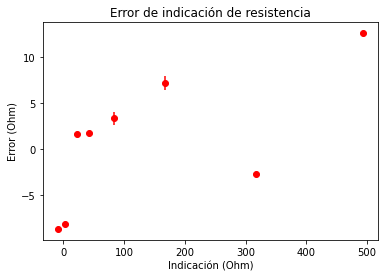

In [17]:
plt.errorbar(resistencias,errorR,yerr=ur,fmt='ro')
plt.xlabel("Indicación (Ohm)")
plt.ylabel("Error (Ohm)")
plt.title("Error de indicación de resistencia")
plt.show()

In [18]:
X=np.hstack((np.ones((len(resistencias),1)),resistencias.reshape((len(resistencias),1)),resistencias.reshape((len(resistencias),1))**2,resistencias.reshape((len(resistencias),1))**3))

In [19]:
cov=np.linalg.inv(np.matmul(X.T,X))
b=np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T,X)),X.T),errorR)
y_pred=np.matmul(X,b)
e=errorR-y_pred
var=e**2/(len(resistencias)-1)

In [20]:
w=var+ur**2
W=np.zeros((len(resistencias),len(resistencias)))
for i in range(len(W)):
    W[i,i]=1/w[i]

In [21]:
cov_WLSR=np.linalg.inv(np.matmul(np.matmul(X.T,W),X))
b_WLSR=np.matmul(np.matmul(np.matmul(cov_WLSR,X.T),W),errorR)
y_pred=np.matmul(X,b_WLSR)
eR=errorR-y_pred
varR=eR**2/(len(errorR)-1)

In [22]:
cov_WLSR

array([[ 7.69532744e-03, -1.49552576e-04,  6.15932239e-07,
        -6.98349705e-10],
       [-1.49552576e-04,  1.19856820e-05, -5.92903727e-08,
         7.22188048e-11],
       [ 6.15932239e-07, -5.92903727e-08,  3.00876074e-10,
        -3.71712177e-13],
       [-6.98349705e-10,  7.22188048e-11, -3.71712177e-13,
         4.63160034e-16]])

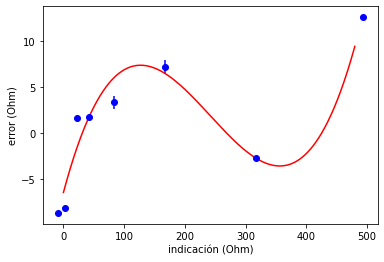

In [23]:
plt.errorbar(X[:,1],errorR,yerr=ur,fmt="bo")
plt.plot(x_test,x_test**3*b_WLSR[3]+x_test**2*b_WLSR[2]+x_test*b_WLSR[1]+b_WLSR[0],color="red")
plt.xlabel("indicación (Ohm)")
plt.ylabel("error (Ohm)")
plt.show()

In [24]:
b_WLSR

array([-6.43938577e+00,  2.47389339e-01, -1.32032813e-03,  1.82073051e-06])

In [25]:
coefR=mnormal(b_WLSR,cov_WLSR,size=N)
a1,a2,a3,a4=coefR[:,0],coefR[:,1],coefR[:,2],coefR[:,3]

## Temperatura

In [26]:
datat.keys()

dict_keys(['17°C1.txt', '21°C1.txt', '25°C1.txt', '29°C1.txt', '33°C1.txt'])

In [27]:
ut=[]
temperaturas=[]
patront=[17.1275,21.0811,25.0982,29.0271,33.9995]
for i in datat.keys():
    t=[]
    u=[]
    for j in range(len(datat[i])):
        if j==0:
            n=datat[i][j][-1]
            t.append(datat[i][j][0][0][0])
            u.append(datat[i][j][0][1][1])
        else:
            t.append(datat[i][j][0][0])
            u.append(datat[i][j][1][0])
    temperaturas.append(Media(np.array(t),np.array(u),n))
    ut.append(Desviación(np.array(t),np.array(u),n))

In [28]:
temperaturas, ut = zip(*sorted(zip(temperaturas, ut)))

In [29]:
patront=np.array(patront)
temperaturas=np.array(temperaturas)
ut=np.array(ut)

In [30]:
x_test=np.arange(15,33+0.2,0.2)

In [31]:
errorT=temperaturas-patront

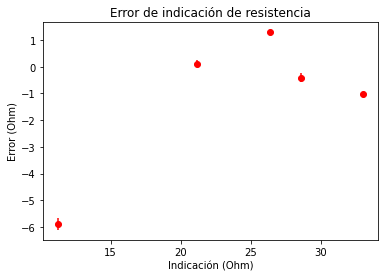

In [32]:
plt.errorbar(temperaturas,errorT,yerr=ut,fmt='ro')
plt.xlabel("Indicación (Ohm)")
plt.ylabel("Error (Ohm)")
plt.title("Error de indicación de resistencia")
plt.show()

In [33]:
X=np.hstack((np.ones((len(temperaturas),1)),temperaturas.reshape((len(temperaturas),1)),temperaturas.reshape((len(temperaturas),1))**2))

In [34]:
cov=np.linalg.inv(np.matmul(X.T,X))
b=np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T,X)),X.T),errorT)
y_pred=np.matmul(X,b)
eT=errorT-y_pred
varT=eT**2/(len(temperaturas)-1)

In [35]:
w=varT+ut**2
W=np.zeros((len(temperaturas),len(temperaturas)))
for i in range(len(W)):
    W[i,i]=1/w[i]

In [36]:
cov_WLST=np.linalg.inv(np.matmul(np.matmul(X.T,W),X))
b_WLST=np.matmul(np.matmul(np.matmul(cov_WLST,X.T),W),errorT)
y_pred=np.matmul(X,b_WLST)
eT=errorT-y_pred
varT=eT**2/(len(errorT)-1)

In [37]:
b_WLST

array([-20.45110103,   1.65987922,  -0.03246363])

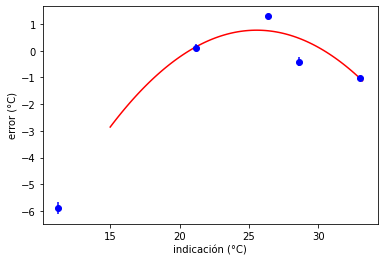

In [38]:
plt.errorbar(temperaturas,errorT,yerr=ut,fmt='bo')
plt.plot(x_test,b_WLST[2]*x_test**2+b_WLST[1]*x_test+b_WLST[0],color="red")
plt.xlabel("indicación (°C)")
plt.ylabel("error (°C)")
plt.show()

In [39]:
cov_WLST

array([[ 6.78513077e-01, -5.96233600e-02,  1.19799823e-03],
       [-5.96233600e-02,  5.49696064e-03, -1.13635369e-04],
       [ 1.19799823e-03, -1.13635369e-04,  2.39519795e-06]])

In [40]:
coefT=mnormal(b_WLST,cov_WLST,size=N)
b1,b2,b3=coefT[:,0],coefT[:,1],coefT[:,2]

In [41]:
u_temp=uniform(-1/2,1/2,size=N)+normal(0,np.sqrt(np.max(varT)),size=N)

In [42]:
u_resist=uniform(-1/2,1/2,size=N)+normal(0,np.sqrt(np.max(varR)),size=N)

## Conductividad

A partir de las calibraciones en resistencia y temperatura, se hicieron los ajustes al código del sensor de forma que a la hora de medir los valores en la disolución directamente se tuvieran las correcciones pertinentes.

In [43]:
área=(5.7357e-3+uniform(-0.001e-3,0.001e-3,size=N))**2

In [44]:
distancia=3e-2+uniform(-0.01e-3,0.01e-3,size=N)

In [45]:
datak.keys()

dict_keys(['0.1980M', '0.9076M', '1.6172M', '3.1789M', '4.1726M', '5.1653M'])

In [46]:
datak['0.1980M'][0][0][0]

[1.354663461538455, 676.787692307692, 18.443413461538494, 64.77211538461543]

In [47]:
uk=[]
urk=[]
utk=[]
resistenciask=[]
conductividades=[]
temperaturask=[]
for i in datak.keys():
    k=[]
    r=[]
    t=[]
    ukk=[]
    urr=[]
    utt=[]
    for j in range(len(datak[i])):
        if i=="0.1980M":
            t.append(datak[i][j][0][0][2])
            utt.append(datak[i][j][0][1][2])
        else:
            t.append(datak[i][j][0][0][3])
            utt.append(datak[i][j][0][1][3])
            
        n=datak[i][j][-1]
        k.append(datak[i][j][0][0][0])
        ukk.append(datak[i][j][0][1][0])
        r.append(datak[i][j][0][0][1])
        urr.append(datak[i][j][0][1][1])
    conductividades.append(Media(np.array(k),np.array(ukk),n))
    uk.append(Desviación(np.array(k),np.array(ukk),n))
    resistenciask.append(Media(np.array(r),np.array(urr),n))
    urk.append(Desviación(np.array(r),np.array(urr),n))
    temperaturask.append(Media(np.array(t),np.array(utt),n))
    utk.append(Desviación(np.array(t),np.array(utt),n))

In [48]:
conductividades, uk, resistenciask, urk, temperaturask, utk = zip(*sorted(zip(conductividades, uk, resistenciask, urk, temperaturask, utk)))

In [49]:
conductividades=np.array(conductividades)
uk=np.array(uk)

In [50]:
resistenciask=np.array(resistenciask)
urk=np.array(urk)

In [51]:
temperaturask=np.array(temperaturask)
utk=np.array(utk)

In [52]:
kappa_calc=[]
uk_calc=[]
for i in range(len(resistenciask)):
    kappa=distancia/normal(resistenciask[i],urk[i],size=N)/área
    kappa_calc.append(kappa.mean())
    uk_calc.append(kappa.std())

In [53]:
kappa_calc=np.array(kappa_calc)
uk_calc=np.array(uk_calc)

Se calcula un error normalizado:

In [54]:
np.abs(kappa_calc-conductividades)/np.sqrt((2*uk_calc)**2+(2*uk)**2)

array([0.29090934, 0.00118893, 0.00834302, 0.00176655, 0.03243896,
       0.02803073])

Se observa que la variabilidad observaba en la conductividad se describe entonces por completo a partir de la variabilidad de la resistencia y de la constante de la celda.

## Concentración

In [55]:
volumen=(50+uniform(-0.05,0.05,size=(N)))/1000
masas=58.443*np.array([0.0099,0.04538,0.08086,0.158945,0.20863,0.258265]).reshape(6,1)+normal(-0.00022,0.00069/2,size=(6,N))

In [56]:
concentración=masas/58.443/volumen

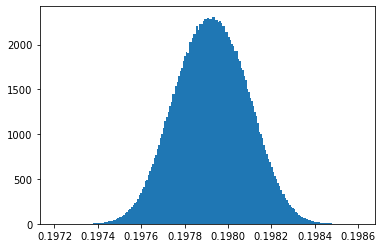

In [57]:
plt.hist(concentración[0],bins=200,density=True)
plt.show()

In [58]:
concentración[0].mean(),concentración[0].std()

(0.197924676194218, 0.0001641039243665944)

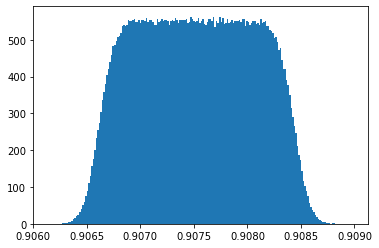

In [59]:
plt.hist(concentración[1],bins=200,density=True)
plt.show()

In [60]:
concentración[1].mean(),concentración[1].mean()-concentración[1].min()

(0.9075242216632794, 0.001382200439673631)

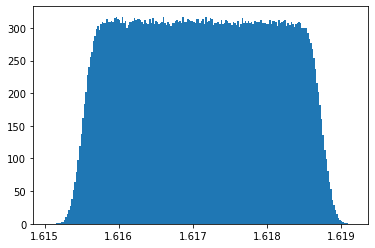

In [61]:
plt.hist(concentración[2],bins=200,density=True)
plt.show()

In [62]:
concentración[2].mean(),concentración[2].mean()-concentración[2].min()

(1.6171236296638922, 0.002070011845287434)

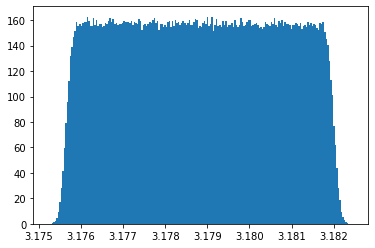

In [63]:
plt.hist(concentración[3],bins=200,density=True)
plt.show()

In [64]:
concentración[3].mean(),concentración[3].mean()-concentración[3].min()

(3.17882254251468, 0.0035903485967736515)

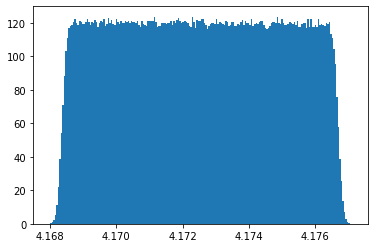

In [65]:
plt.hist(concentración[4],bins=200,density=True)
plt.show()

In [66]:
concentración[4].mean(),concentración[4].mean()-concentración[4].min()

(4.172522276349718, 0.004572153967039583)

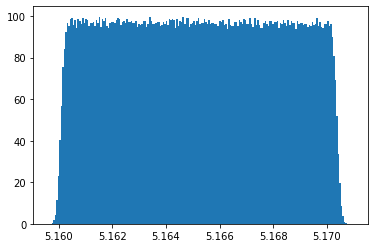

In [67]:
plt.hist(concentración[5],bins=200,density=True)
plt.show()

In [68]:
concentración[5].mean(),concentración[5].mean()-concentración[5].min()

(5.165221379565043, 0.005610222537583809)

In [69]:
uconc=np.mean(concentración,axis=1)-np.min(concentración,axis=1)

# Conductividad como función de la concentración

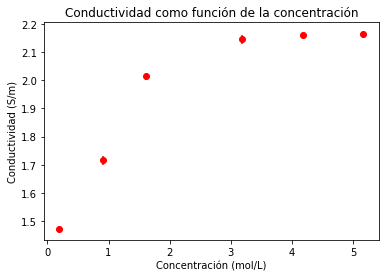

In [70]:
plt.errorbar(np.mean(concentración,axis=1),kappa_calc,xerr=uconc,yerr=uk_calc,fmt="ro")
plt.title("Conductividad como función de la concentración")
plt.xlabel("Concentración (mol/L)")
plt.ylabel("Conductividad (S/m)")
plt.show()

In [71]:
mediaT=Media(temperaturask,utk,6)
uT=Desviación(temperaturask,utk,6)
mediaT,uT

(22.862658992689816, 0.7612056965630674)

In [72]:
def KappaTC(X,p1,p2,p3,p4,n):
    t=X[:,0]
    c=X[:,1]
    return (p1+p2*t)*c**n*np.exp(-p3*c/(t-p4))

In [73]:
X=np.hstack((np.ones((len(np.mean(concentración,axis=1)),1))*mediaT,np.mean(concentración,axis=1).reshape((len(np.mean(concentración,axis=1)),1))))

In [74]:
coefs,cov=curve_fit(KappaTC,X,kappa_calc ,p0=np.array([1.818,-442.0,160.4,-616.1,1.0]))

In [75]:
coefs

array([ 1.47413323e+06, -6.44776865e+04,  3.52317369e+03, -1.65682659e+05,
        1.60273344e-01])

In [76]:
cov

array([[-2.33324791e+13,  1.02054967e+12, -1.76711729e+16,
         8.31128758e+17,  2.58365213e+04],
       [ 1.02144975e+12, -4.46776442e+10,  7.53032898e+14,
        -3.54174168e+16, -1.10098792e+03],
       [-2.59261188e+16,  1.13399405e+15,  5.73045571e+20,
        -2.69520680e+22, -8.37830946e+08],
       [ 1.21938385e+18, -5.33351732e+16, -2.69520680e+22,
         1.26763735e+24,  3.94057439e+10],
       [ 3.79058094e+04, -1.65797880e+03, -8.37830979e+08,
         3.94057453e+10,  5.73549315e-03]])

In [77]:
c_test=np.arange(0.198,6+0.1,0.1)

In [78]:
X_test=np.hstack((np.ones((len(c_test),1))*mediaT,c_test.reshape((len(c_test),1))))

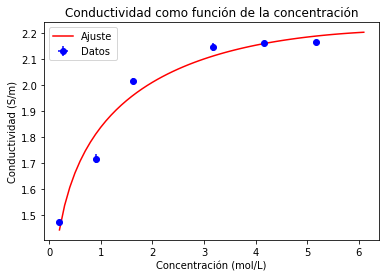

In [79]:
plt.plot(c_test,KappaTC(X_test,coefs[0],coefs[1],coefs[2],coefs[3],coefs[4]),color="red")
plt.errorbar(np.mean(concentración,axis=1),kappa_calc,xerr=uconc,yerr=uk_calc,fmt="bo")
plt.legend(["Ajuste","Datos"])
plt.title("Conductividad como función de la concentración")
plt.xlabel("Concentración (mol/L)")
plt.ylabel("Conductividad (S/m)")
plt.show()